In [1]:
import json
import evaluate
import pandas as pd
import random
from datasets import load_dataset,concatenate_datasets, Dataset
from IPython.display import clear_output

accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")

def sampling(dataset,target,pos_n_sample,neg_n_sample,seed=0):
    random.seed(seed)
    neg_ds = dataset.filter(lambda example: example[target]==False or example[target] == "0")
    pos_ds = dataset.filter(lambda example: example[target]==True or example[target] == "1")
    neg_sampled_indices = random.sample(range(0, len(neg_ds)), neg_n_sample)
    pos_sampled_indices = random.sample(range(0, len(pos_ds)), pos_n_sample)
    neg_selected_ds = neg_ds.select(neg_sampled_indices)
    pos_selected_ds = pos_ds.select(pos_sampled_indices)
    combined_ds = concatenate_datasets([neg_selected_ds, pos_selected_ds]).shuffle(seed=seed)
    return combined_ds

def filter_valid(preds, labels):
    filtered_label, filtered_pred = zip(*[(label, pred) for pred, label in zip(preds, labels) if pred != '-1'])
    return filtered_label, filtered_pred

def calculate_valid(preds,labels):
    try:
        filtered_labels, filtered_preds = filter_valid(preds, labels)
    except ValueError:
        filtered_labels, filtered_preds = [],[]
        valid_acc,valid_f1,valid_rec = 0,0,0
    else:
        valid_acc = accuracy_metric.compute(predictions=filtered_preds, references=filtered_labels)['accuracy']*100
        valid_f1 = f1_metric.compute(predictions=filtered_preds, references=filtered_labels)['f1']*100
        valid_rec = len(filtered_labels)/len(labels)*100
    return valid_acc,valid_f1,valid_rec

def calculate_overall(preds,labels):
    acc = accuracy_metric.compute(predictions=preds, references=labels)['accuracy']*100
    f1_macro = f1_metric.compute(predictions=preds, references=labels,average='macro' )['f1']*100
    return acc,f1_macro

def contains_keyword(sentence, keywords):
    for keyword in keywords:
        if keyword.lower() in sentence.lower():
            return True
    return False

def paper_method(raw_texts,positive_kw,negative_kw):
    preds_list =[]
    for text in raw_texts:
        short_ans = text.lower().replace(',','.').split('.')[0]
        if 'yes' in short_ans and 'no' not in short_ans:
            preds_list.append("1")
        elif 'no' in short_ans and 'yes' not in short_ans:
            preds_list.append("0")
        elif contains_keyword(text, positive_kw):
            preds_list.append("1")
        elif contains_keyword(text, negative_kw):
            preds_list.append("0")
        else:
            preds_list.append("-1")
    return preds_list

def summary_table_sampling(file_list,path,pos_n_sample,neg_n_sample,positive_kw,negative_kw):
    df = pd.DataFrame(columns=['model','PEFT','%overall_acc','%overall_f1_macro','%valid_rec' ,'%valid_acc', '%valid_f1'])
    for file in file_list:
        try:
            with open(path[0]+file+path[1], 'r') as f:
                data = json.load(f)
        except FileNotFoundError:
            pass
        else:
            data = [content[0] for content in data]
            dataset_clean = Dataset.from_pandas(pd.DataFrame(data=data))
            data = sampling(dataset_clean,"true_label",pos_n_sample,neg_n_sample)
            
            labels = [label['true_label'] for label in data]
            raw_texts = [text['raw_text'].split("\nAnswer:")[-1] for text in data]
            preds = paper_method(raw_texts,positive_kw,negative_kw)
            acc,f1_macro = calculate_overall(preds,labels)
            valid_acc,valid_f1,valid_rec = calculate_valid(preds,labels)
            clear_output(wait=True)
            df.loc[len(df)] = {'model': file.split('-')[0], 
                               'PEFT': file.split('-')[1],
                               '%overall_acc':round(acc, 2),
                               '%overall_f1_macro':round(f1_macro, 2),
                               '%valid_rec':round(valid_rec, 2) ,
                               '%valid_acc':round(valid_acc, 2), 
                               '%valid_f1':round(valid_f1, 2)}
    return df

def wrangling_table(df_ori):
    df =df_ori.copy()
    old_label = ['lora','ia3','ptuning','parallel','adapterp','adapterh','fft']
    new_label = ['LoRA','IA3','P-Tuning','Parallel','AdapterP','AdapterH','FFT']
    model_old = ['1b','3b','7b','15b']
    model_new = ['1B','3B','7B','15.5B']
    df['PEFT'] = df['PEFT'].replace(dict(zip(old_label, new_label)))
    df['model'] = df['model'].replace(dict(zip(model_old, model_new)))
    df['PEFT'] = pd.Categorical(df['PEFT'], categories=new_label, ordered=True)
    df['model'] = pd.Categorical(df['model'], categories=model_new, ordered=True)
    df = df.sort_values(by=['PEFT','model']).reset_index(drop=True)
    return df

In [2]:
models = ['1b', '3b', '7b', '15b']
methods = ['lora','ia3','ptuning','parallel','adapterp','adapterh','fft']
file_list = [f"{model}-{method}" for method in methods for model in models]

In [3]:
import matplotlib.pyplot as plt
import numpy as np
color_dict = {
    'LoRA': '#4B527E',
    'IA3': '#3085C3',
    'P-Tuning': '#D988B9',
    'Parallel': '#004225',
    'AdapterP': '#79AC78',
    'AdapterH': '#B0D9B1',
    'FFT': '#C70039'
} # https://colorhunt.co/

marker_dict = {
    'LoRA': 'o',  # circle
    'IA3': 'p',  # triangle_up
    'P-Tuning': 'P',  # plus (filled)
    'Parallel': 'X',  # x (filled)
    'AdapterP': 'v',  # triangle_down
    'AdapterH': 'H',  # triangle_left
    'FFT': '>',  # triangle_right
}

def plot_acc_f1(df, task):
    # Create two subplots
    plt.rcParams.update({'font.size': 12.5})
    fig, axs = plt.subplots(1, 2, figsize=(12, 4.8), sharey=True)
    # Plotting %Overall Accuracy
    for peft in df['PEFT'].unique():
        subset = df[df['PEFT'] == peft]
        axs[0].plot(subset['model'], subset['%overall_acc'], label=peft, marker=marker_dict[peft], color=color_dict[peft], linewidth=1.5, markersize=8)
        axs[1].plot(subset['model'], subset['%overall_f1_macro'], label=peft, marker=marker_dict[peft], color=color_dict[peft], linewidth=1.5, markersize=8)
    axs[0].set_ylabel('Accuracy (%)',fontsize=14)
    axs[1].set_ylabel('F1 score (%)',fontsize=14)
    axs[0].set_title(f'Accuracy Per Model Size ({task})')
    axs[1].set_title(f'F1 Score Per Model Size ({task})')
    handles, labels = axs[0].get_legend_handles_labels()
    # Setting the shared legend position at the bottom outside the plots using the fetched handles and labels
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.05), ncol=len(df['PEFT'].unique()))
    plt.tight_layout()
    plt.show()

def plot_compare(df1, df2, metric,task):
    # Create two subplots
    plt.rcParams.update({'font.size': 12.5})
    fig, axs = plt.subplots(1, 2, figsize=(12, 4.8), sharey=True)
    # Plotting %Overall Accuracy
    for peft in df1['PEFT'].unique():
        subset = df1[df1['PEFT'] == peft]
        subset2 = df2[df2['PEFT'] == peft]
        axs[0].plot(subset['model'], subset[metric], label=peft, marker=marker_dict[peft], color=color_dict[peft], linewidth=1.5, markersize=8)
        axs[1].plot(subset2['model'], subset2[metric], label=peft, marker=marker_dict[peft], color=color_dict[peft], linewidth=1.5, markersize=8)
    axs[0].set_ylabel(f'{metric} (%)',fontsize=14)
    axs[0].set_title(f'{task}')
    axs[1].set_title(f'{task} (one-shot)')
    handles, labels = axs[0].get_legend_handles_labels()
    # Setting the shared legend position at the bottom outside the plots using the fetched handles and labels
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.05), ncol=len(df1['PEFT'].unique()))
    plt.tight_layout()
    plt.show()

    #'%overall_acc'
    #'%overall_f1_macro'

## Defect detection <br>
(Don't for get change file path before run)<br>

Prompt format:<br>
instruction = '''Is there a defect in the Code, and respond to YES or NO.''' <br>
prompt= f'''Question: {code}\n{instruction}\n\nAnswer:'''

In [4]:
defect_positive = ['there is a','ere is a','has a defect','contains a defect']
defect_negative = ['there is no defect']
dd_path = ['../outputs/defect_detection/generations-defectdetection-starcoderbase-','.json'] # File path

defect_df = summary_table_sampling(file_list,dd_path,919,1081,defect_positive,defect_negative)
#defect_df

Filter:   0%|          | 0/2732 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2732 [00:00<?, ? examples/s]

In [5]:
defect_positive = ['there is a','ere is a','has a defect','contains a defect']
defect_negative = ['there is no defect']
dd_path = ['../outputs/defect_detection_ablation/defect_generations_','_os.json'] # File path

defect_os_df = summary_table_sampling(file_list,dd_path,919,1081,defect_positive,defect_negative)
#defect_os_df

Filter:   0%|          | 0/2732 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2732 [00:00<?, ? examples/s]

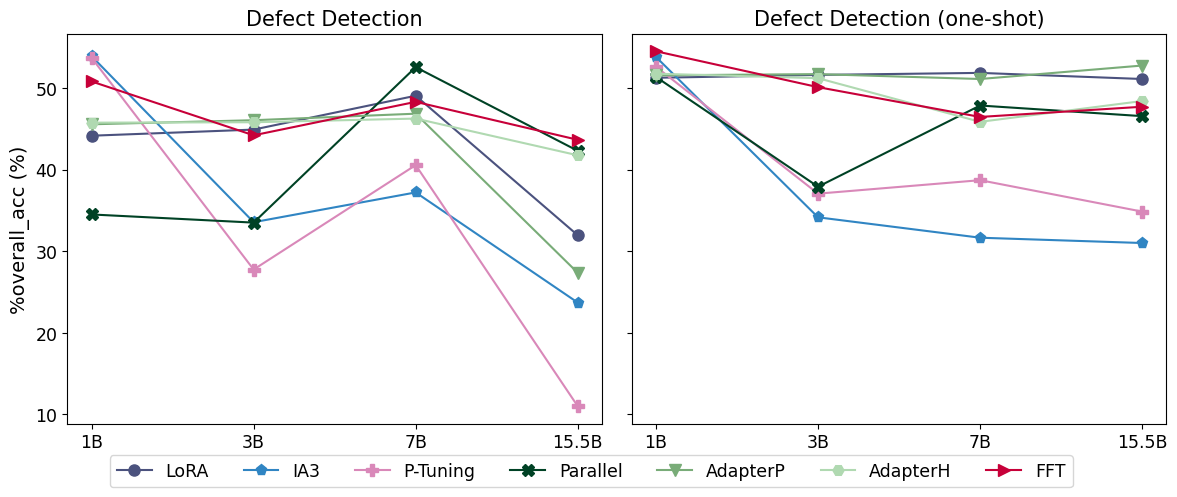

In [6]:
df1 = wrangling_table(defect_df)
df2 = wrangling_table(defect_os_df)
plot_compare(df1, df2, "%overall_acc","Defect Detection")

## Clone detection <br>
(Don't for get change file path before run)<br>

Prompt format:<br>
instruction= '''Is there a clone relation between the Code1 and Code2, and respond to YES or NO.''' <br>
code1= doc['func1'] <br>
code2= doc['func2'] <br>
prompt= f'''Question: Code1: {code1}.\nCode2: {code2}.\n{instruction}\n\nAnswer:''' <br>


In [7]:
clone_positive = ['there is a','ere is a']
clone_negative = ['there is no']
cd_path = ['../outputs/clone_detection/generations-clonedetection-starcoderbase-','.json']

clone_df = summary_table_sampling(file_list,cd_path,274,1726,clone_positive,clone_negative)
#clone_df

Filter:   0%|          | 0/2726 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2726 [00:00<?, ? examples/s]

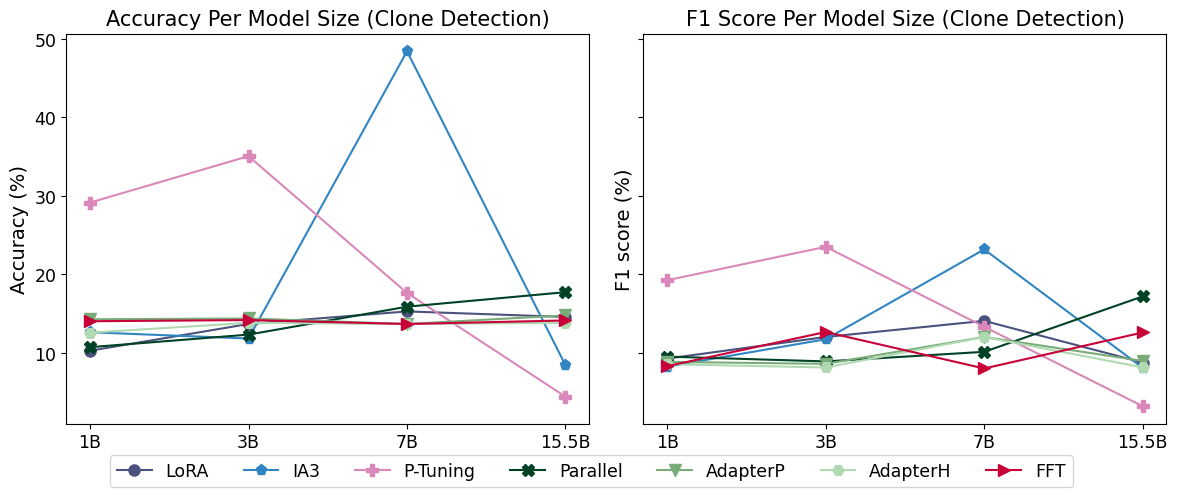

In [8]:
plot_acc_f1(wrangling_table(clone_df), "Clone Detection")

In [9]:
clone_positive = ['there is a','ere is a']
clone_negative = ['there is no']
cd_path = ['../outputs/clone_detection_ablation/clone_generations_','_os.json']

clone_os_df = summary_table_sampling(file_list,cd_path,274,1726,clone_positive,clone_negative)
#clone_os_df

Filter:   0%|          | 0/2726 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2726 [00:00<?, ? examples/s]

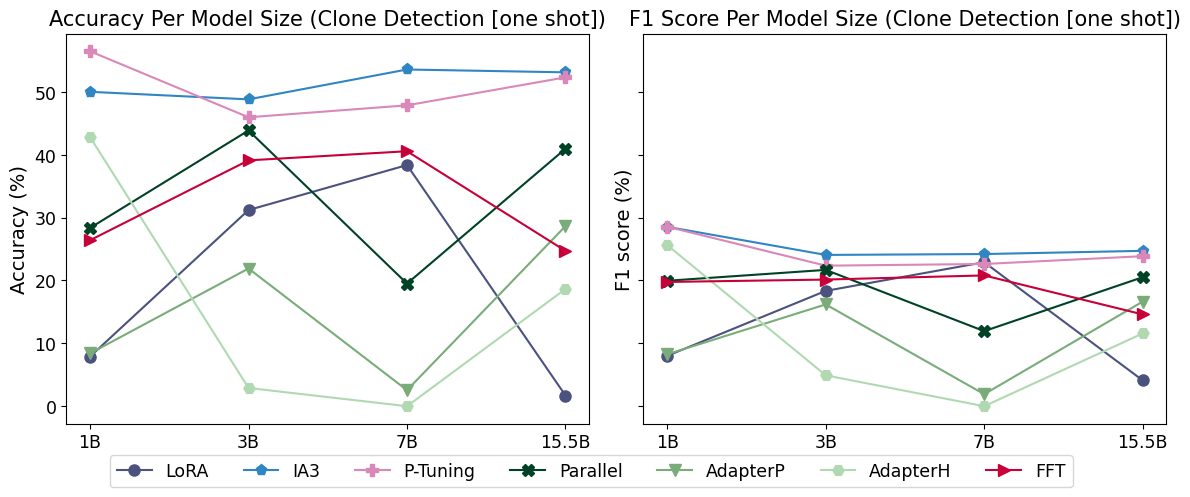

In [10]:
plot_acc_f1(wrangling_table(clone_os_df), "Clone Detection [one shot]")